In [8]:
import matplotlib.pyplot as plt
import torch
from utils.graph_plotting import superpixels_to_2d_image
from DataModules import MNISTSuperpixelDataModule
import itertools

cuda_available = torch.cuda.is_available()
print(f"Cuda available: {cuda_available}")
device = torch.device("cuda" if cuda_available else "cpu")


MNIST_PATH = "../datasets/MNISTSuperpixel"

Cuda available: True


In [33]:
data_module = MNISTSuperpixelDataModule(MNIST_PATH)
data_module.setup("fit")
data_loader = data_module.train_dataloader()


/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


(780, 780, 1)
(780, 780, 1)
(780, 780, 1)
(780, 780, 1)
(780, 780, 1)
(780, 780, 1)


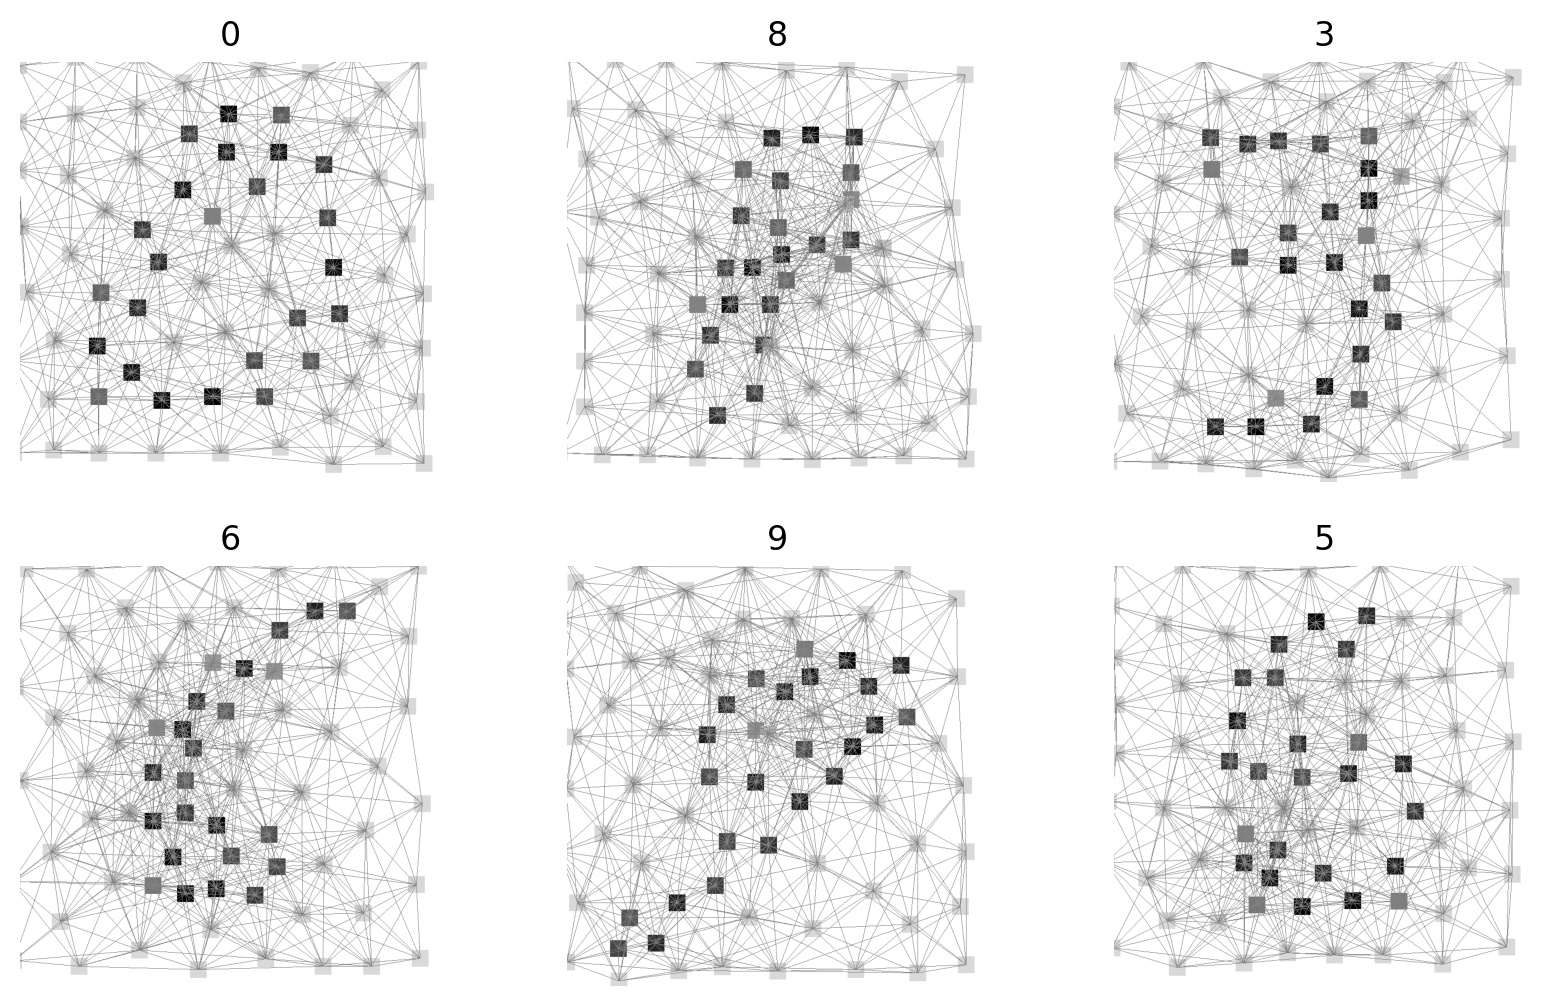

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axes = axes.flatten()
data_loader_iter = iter(data_loader)
batch = next(data_loader_iter)
for i in range(len(axes)):
    image = superpixels_to_2d_image(batch[i])
    print(image.shape)
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{batch[i].y.item()}")
plt.show()

In [24]:
import numpy as np
a = np.array([[1, 2, 3],[1, 2, 3]])
b = np.array([[4, 5, 6],[4, 5, 6]])
c = np.array([[7, 8, 9],[7, 8, 9]])
d = np.array([[7, 7, 7],[8, 8, 8]])

stack = np.stack((a,b,c,d), axis=0)
stack.shape

(4, 2, 3)

In [40]:
test_batch = data_loader.dataset[:4]
test_batch[2]

Data(x=[75, 1], edge_index=[2, 1301], y=[1], pos=[75, 2], edge_attr=[1301, 2])

(780, 780, 1)
(780, 780, 1)
(780, 780, 1)
(780, 780, 1)


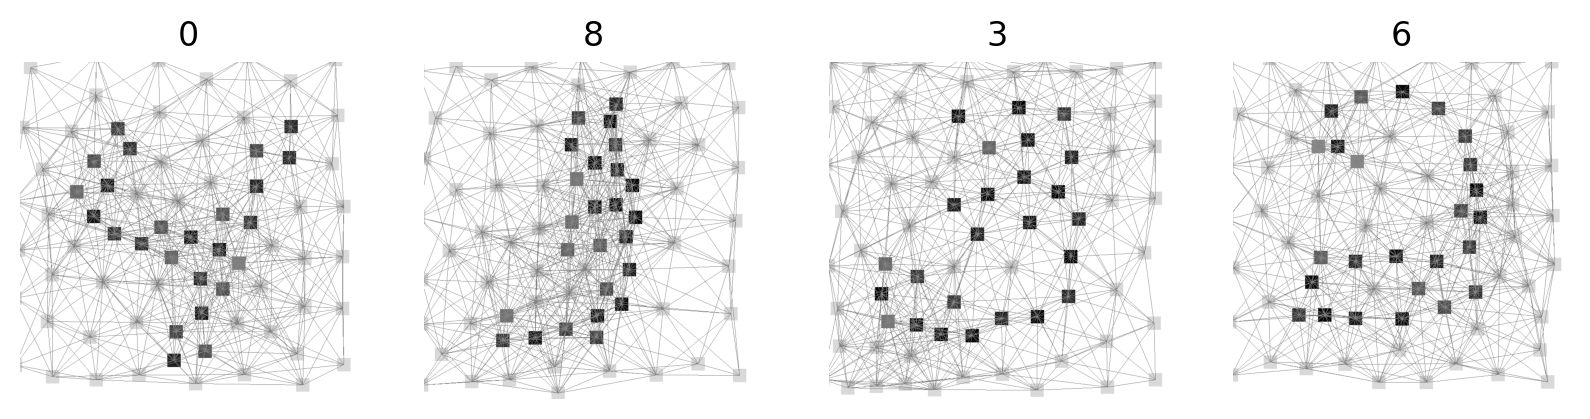

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(10, 6), dpi=200)
axes = axes.flatten()
for i in range(len(axes)):
    image = superpixels_to_2d_image(test_batch[i])
    print(image.shape)
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{batch[i].y.item()}")
plt.show()